In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


from scipy import stats



from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.metrics import f1_score,classification_report
from sklearn.ensemble import RandomForestClassifier


from statsmodels.formula.api import ols
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

### Importation CSV et création du dataframe

In [52]:
df = pd.read_csv("data.csv")
df.NewExist = df.NewExist.astype(str)
df.UrbanRural= df.UrbanRural.astype(str)
df.Real_estate = df.Real_estate.astype(str)
df

,State,Industry,Term,GrAppv,MIS_Status,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,Real_estate
0,IN,Retail trade,84,60000.0,0,4,1,0,1,1,0,0
1,IN,Accommodation and food services,60,40000.0,0,2,1,0,1,1,0,0
2,IN,Health care and social assistance,180,287000.0,0,7,0,0,1,1,0,0
3,OK,Others,60,35000.0,0,2,0,0,1,1,0,0
4,FL,Others,240,229000.0,0,14,0,7,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
894956,OH,Retail trade,60,70000.0,0,6,0,0,1,1,0,0
894957,OH,Retail trade,60,85000.0,0,6,0,0,1,1,0,0
894958,CA,Manufacturing,108,300000.0,0,26,0,0,1,1,0,0
894959,HI,Others,60,75000.0,1,6,0,0,1,1,0,0


In [53]:
df.FranchiseCode = df.FranchiseCode.apply(lambda x: 1 if x ==1 else 0)
df.FranchiseCode = df.FranchiseCode.astype(str)
df.FranchiseCode.value_counts()


1    790187
0    104774
Name: FranchiseCode, dtype: int64

### Création de la matrice X (variables explicatives) et de la série y (variable cible)

In [54]:
X = df.drop(['MIS_Status'], axis=1)
y = df['MIS_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.8, random_state=42, stratify=y)

# Score du dummy classifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)



0.8248925935651115

### Création d'un pipeline

In [55]:
transformer = make_column_transformer(
    (OneHotEncoder(),make_column_selector(dtype_exclude=np.number)),
    (StandardScaler(),make_column_selector(dtype_include=np.number))
    )

### Création d'un  RandomForest

In [56]:
forest= make_pipeline(
    transformer,
    RandomForestClassifier(
        max_depth=5,
        n_estimators=100,
        min_samples_leaf=1000,
        class_weight='balanced'
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
forest.fit(X_train,y_train)

#Utilisation d'un .features_importances_ pour déterminer quelle variable est importante pour la prédiction
A=forest.named_steps['randomforestclassifier'].feature_importances_

# #Score de notre modèle après la cross_validation
cross_val=cross_validate(forest, X_train, y_train,scoring='f1',cv=5)

cross_val['test_score'].mean()

0.5809533153238309

In [57]:
# y_pred=forest.predict(X_train)
# f1_score(y_train,y_pred)

In [58]:
A_columns=transformer.get_feature_names_out()
A_columns

array(['onehotencoder__State_AK', 'onehotencoder__State_AL',
       'onehotencoder__State_AR', 'onehotencoder__State_AZ',
       'onehotencoder__State_CA', 'onehotencoder__State_CO',
       'onehotencoder__State_CT', 'onehotencoder__State_DC',
       'onehotencoder__State_DE', 'onehotencoder__State_FL',
       'onehotencoder__State_GA', 'onehotencoder__State_HI',
       'onehotencoder__State_IA', 'onehotencoder__State_ID',
       'onehotencoder__State_IL', 'onehotencoder__State_IN',
       'onehotencoder__State_KS', 'onehotencoder__State_KY',
       'onehotencoder__State_LA', 'onehotencoder__State_MA',
       'onehotencoder__State_MD', 'onehotencoder__State_ME',
       'onehotencoder__State_MI', 'onehotencoder__State_MN',
       'onehotencoder__State_MO', 'onehotencoder__State_MS',
       'onehotencoder__State_MT', 'onehotencoder__State_NC',
       'onehotencoder__State_ND', 'onehotencoder__State_NE',
       'onehotencoder__State_NH', 'onehotencoder__State_NJ',
       'onehotencoder__S

In [59]:
df_coeff = pd.DataFrame([A_columns,A], index=['features', 'coeff']).T.explode('coeff')
df_coeff.sort_values(by='coeff', ascending=False).head(20)

,features,coeff
79,standardscaler__Term,0.371399
83,standardscaler__RetainedJob,0.108573
75,onehotencoder__UrbanRural_0,0.10419
78,onehotencoder__Real_estate_1,0.088382
77,onehotencoder__Real_estate_0,0.084958
76,onehotencoder__UrbanRural_1,0.066632
80,standardscaler__GrAppv,0.061413
64,onehotencoder__Industry_Others,0.038194
82,standardscaler__CreateJob,0.024857
81,standardscaler__NoEmp,0.018211


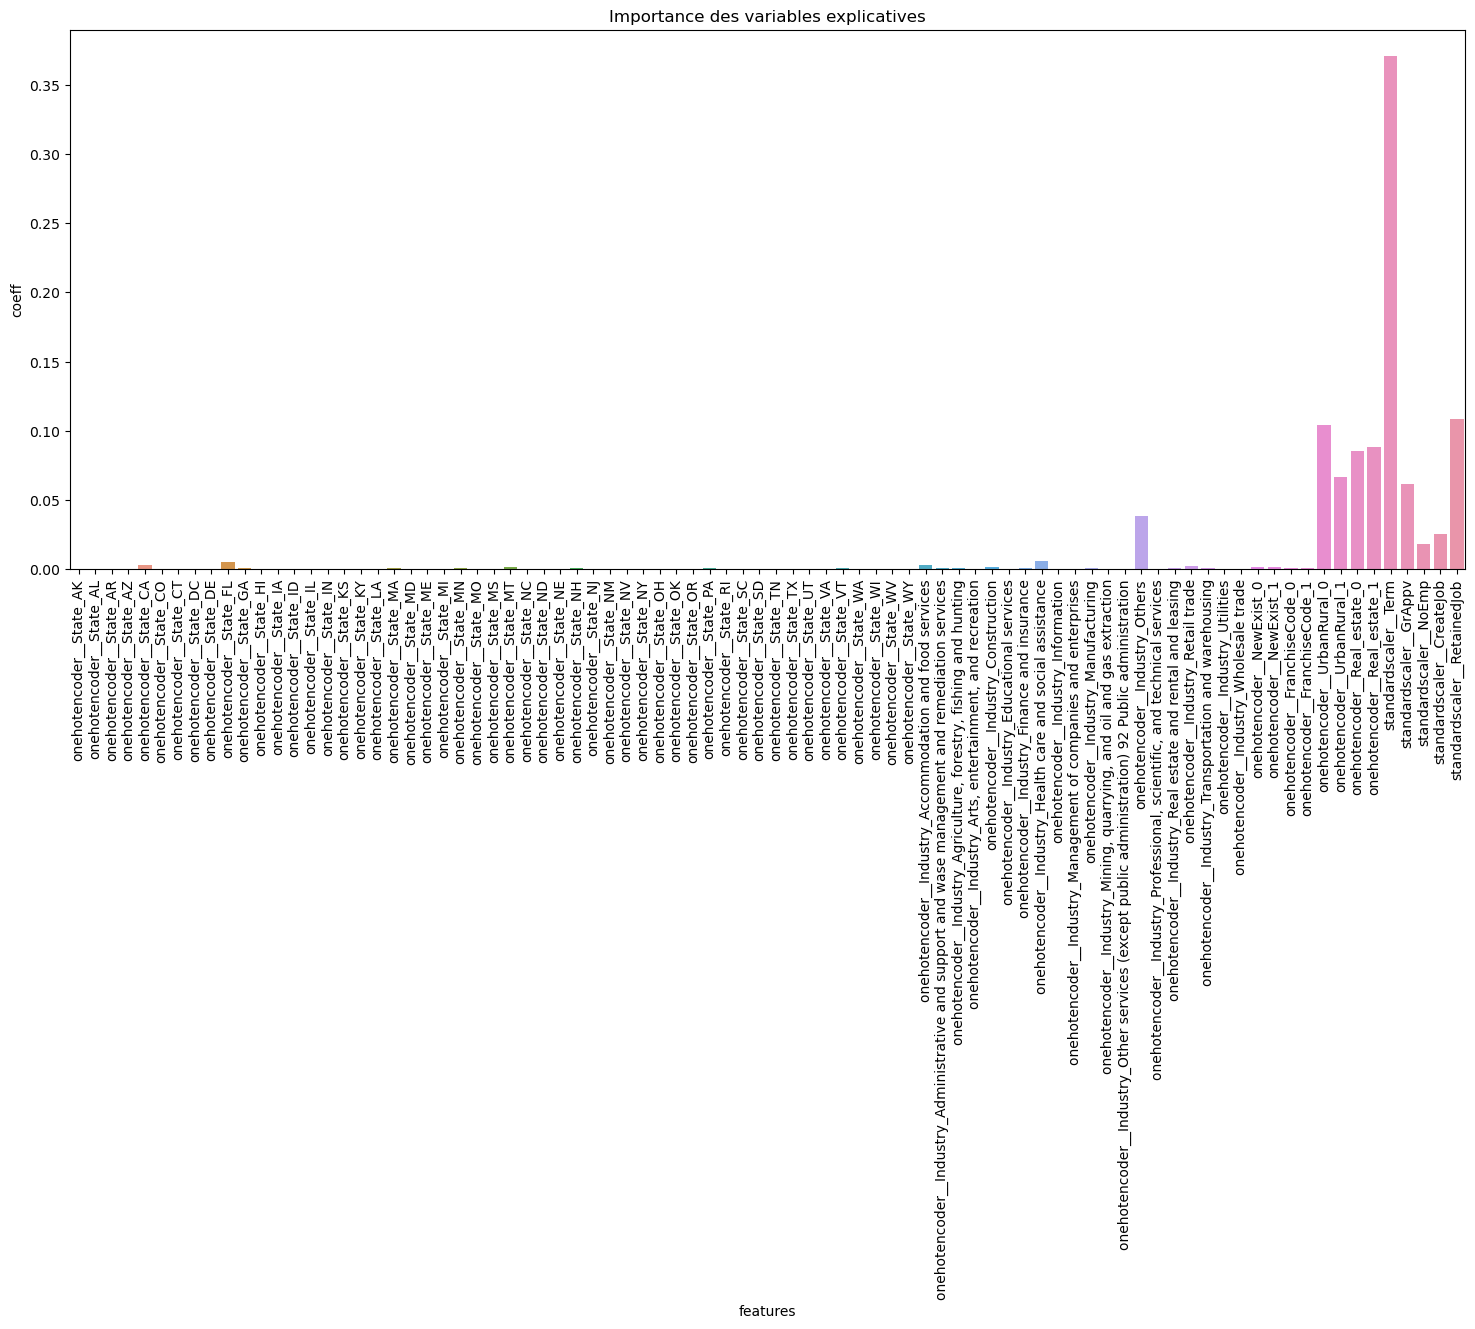

In [60]:
plt.figure(figsize=[18,7])
sns.barplot(data=df_coeff,x='features',y='coeff')
plt.xticks(rotation=90)
plt.title("Importance des variables explicatives")
plt.show()

In [61]:
X = df[['UrbanRural','CreateJob','NoEmp','Real_estate','GrAppv','Industry','Term']]
y = df['MIS_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.8, random_state=42, stratify=y)

In [73]:
forest= make_pipeline(
    transformer,
    RandomForestClassifier(
        max_depth=5,
        n_estimators=100,
        min_samples_leaf=2500,
        min_samples_split=2500,
        class_weight='balanced'
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
forest.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc30a91550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc30a91cd0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_leaf=2500,
                                        min_samples_split=2500))])

In [74]:
y_pred=cross_val_predict(forest,X_train, y_train)

In [75]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86    590599
           1       0.44      0.82      0.57    125369

    accuracy                           0.79    715968
   macro avg       0.70      0.80      0.72    715968
weighted avg       0.86      0.79      0.81    715968



In [76]:
cross_val=cross_validate(forest, X_train, y_train,scoring='f1_macro',cv=5)

cross_val['test_score'].mean()

In [ ]:
# lo_reg = make_pipeline(
#     transformer,
#     LogisticRegression(
#         penalty='l2',
#         solver='saga',
#         class_weight='balanced',
#         multi_class='ovr'
#         )
#     )

# # Entrainement de notre modèle en utilisant les paramètres par défaut 
# lo_reg.fit(X_train,y_train)

# # Score de notre modèle après la cross_validation
# cross_val=cross_validate(lo_reg, X_train, y_train,scoring='f1',cv=5)
# cross_val['test_score'].mean()

### Utilisation d'un RandomSearch pour obtenir une idée de l'ordre de grandeur des paramètres

In [ ]:
#Pour trouver le nom des paramètres
forest.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc40ecfaf0>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc40ecfc70>)])),
  ('randomforestclassifier',
   RandomForestClassifier(class_weight='balanced', max_depth=5))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc40ecfaf0>),
                                 ('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc40ecfc70>)]),
 'randomforestclassifier': RandomForestClassi

In [71]:
param_rand = {'randomforestclassifier__min_samples_leaf':np.arange(1000,10000,100),
              'randomforestclassifier__max_depth':np.arange(5,10,1),
              'randomforestclassifier__min_samples_split':np.arange(1000,10000,100)
                }
                
random_search = RandomizedSearchCV(forest, param_distributions=param_rand,scoring='f1', n_iter=1, cv=5, random_state=42)

random_search.fit(X_train, y_train)
print(random_search.best_params_)

KeyboardInterrupt: 

In [50]:
random_search.best_estimator_
random_search.best_score_

0.5789856443360211

### Utilisation d'un GridSearch pour cibler les meilleurs paramètres

In [47]:
params = {'randomforestclassifier__min_samples_leaf':np.arange(2150,2300,1),
          'randomforestclassifier__max_depth':[6]
            }

grid=GridSearchCV(forest, param_grid=params, scoring='f1', cv=5)
grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
grid.best_score_

0.37606272607064106